In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
# export
class TSMulti(MultiTuple):pass

## Transform catagorical data

In [7]:
# export
class TensorCatI(TensorBase):pass
class CatSeqI(TensorSeqs):pass
def unpack_list(o, r=None):
    r = ifnone(r,L())
    for a in o:
        if isinstance(a,list) or isinstance(a,L):
            r = unpack_list(a, r)
        else:
            r.append(a)
    return r
            
class CatTfm(Transform):
    def __init__(self, df, cat_cols:[]): # maybe change to proccs
        self.vocab,self.o2i = {},{}
        for i, col in enumerate(L(cat_cols)):
            r = unpack_list(list(df[col]))
            self.vocab[i], self.o2i[i] = uniqueify(r, sort=True, bidir=True)
            
    def encodes(self, o:TensorCat):
        r = []
        for i in self.o2i:
            r.append(self.o2i[i][o.o[i]])            
        return TensorCatI(r, label = o._meta['label'])
    
    def decodes(self, o:TensorCatI): 
        r = []
        for i_cat in self.vocab:
            r.append(self.vocab[i_cat][o[i_cat]])
        return TensorCat(r, label = o._meta.get('label',None))
    
    def encodes(self, o:CatSeq):
        r = []
        for i in self.o2i:
            r.append([])
            for a in o.o[i]:
                r[i].append(self.o2i[i][a])            
        return CatSeqI(r, label = o._meta['label'])
    
    def decodes(self, o:CatSeqI):
        r = []
        for i in self.o2i:
            r.append([])
            for a in o[i]:
                r[i].append(self.vocab[i][a])  
        return CatSeq(r, label = o._meta.get('label',None))
    
    

In [8]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a']))
test_eq_type(o_tmf,TensorCatI([0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a']))

In [9]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b']))
test_eq_type(o_tmf,TensorCatI([0,0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b']))

In [10]:
df = pd.DataFrame({'a':[[i,'a'] for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o = CatSeq([['a','b','a','a']], label='a')
o_tmf = tmf(o)
print(o_tmf)
test_eq(o_tmf, TensorCatI([[0, 1, 0, 0]]))
test_eq(o_tmf._meta['label'], 'a')
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeqI([[0, 1, 0, 0]])


CatSeq([['a', 'b', 'a', 'a']], label = ['a'])

In [11]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o = CatSeq([['a','b','a','a'],['b','b','c','c']], label=['a','a_2'])
o_tmf = tmf(o)
print(o_tmf)
test_eq(o_tmf, CatSeqI([[0, 1, 0, 0],
                        [0, 0, 1, 1]]))
test_eq(o_tmf._meta['label'], ['a','a_2'])
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeqI([[0, 1, 0, 0],
        [0, 0, 1, 1]])


CatSeq([['a', 'b', 'a', 'a'], ['b', 'b', 'c', 'c']], label = ['a', 'a_2'])

In [12]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, *args, **kwargs): # maybe change to proccs
        self.f = CatTfm(*args, **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [13]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatMultiTfm(df,'a')
print(tmf)
o = TSMulti(TensorBase([1]), TensorCat('a'))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0])) )
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

CatMultiTfm: True (TSMulti,object) -> encodes (TSMulti_,object) -> decodes


# Dataloader

In [23]:
def get_df():
    return pd.DataFrame(data={'x':[np.arange(100.),
                           np.arange(120.)],
                   'con_ts_0':[np.ones(100)[None,:],
                           np.ones(120)[None,:]],
                   'con_ts_1':[pd.Series(np.arange(100)+np.random.randn(100)),
                           pd.Series(np.arange(120)+np.random.randn(120))],
                   'var_0':[0.,1.],
                   'var_1':[2.,1.5],
                   'cat_ts_0':[L(['a','b']*50),L(['b','a','b']*40)],
                   'cat_ts_1':[L(['y','z']*50),L(['x','y','z']*40)],
                   'con_0':['a','b'],
                   'con_1':['d','c']
                       })
df = get_df()
df

,x,con_ts_0,con_ts_1,var_0,var_1,cat_ts_0,cat_ts_1,con_0,con_1
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","0 -0.617810 1 1.428506 2 2.662515 3 2.044217 4 4.670755 ... 95 94.512024 96 93.138901 97 96.355890 98 98.152642 99 98.355421 Length: 100, dtype: float64",0.0,2.0,"[a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b, a, b]","[y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z, y, z]",a,d
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, ...]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]]","0 -1.480290 1 1.635890 2 2.616556 3 4.088941 4 5.006840 ... 115 115.920240 116 116.319758 117 118.124653 118 117.602981 119 117.641192 Length: 120, dtype: float64",1.0,1.5,"[b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, a, b, b, ...]","[x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, y, z, x, ...]",b,c


In [24]:
# export
def array2series(o):
    return pd.Series(o.flatten())
def arrays2series(s:pd.Series):
    return pd.Series([array2series(o) for o in s])

In [25]:
df = pd.DataFrame(data={'x':  [np.arange(10.),
                               np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [26]:
# hide
df = pd.DataFrame(data={'x':  [np.arange(10.)]*100,
                       'ts_0':[np.ones(10)[None,:]]*100,
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [27]:
# export
def reconize_cols(dataset):
    con_names, cat_names, con_ts_names, cat_ts_names, classes = L(), L(), L(), L(), {}
    for col in dataset.columns:
        t = type(dataset[col].iloc[0])
        if t is pd.core.series.Series:
            con_ts_names.append(col)
        elif t is np.ndarray:
            o = arrays2series(dataset[col])
            dataset[col] = o
            con_ts_names.append(col)
        elif isinstance(dataset[col].iloc[0], str):
            cat_names.append(col)
            classes[col] = uniqueify(list(dataset[col].values))
        elif isinstance(dataset[col].iloc[0], float) or isinstance(dataset[col].iloc[0], int) or t is np.int64:
            con_names.append(col)            
        elif isinstance(dataset[col].iloc[0], L) or isinstance(dataset[col].iloc[0],list):
            cat_ts_names.append(col)
            classes[col] = uniqueify(unpack_list(list(dataset[col])))
        else:
            raise Exception(t)
    return con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset

In [35]:
df = get_df()
con_names, cat_names, con_ts_names, cat_ts_names, classes, dataset = reconize_cols(df)
test_eq(con_names, ['var_0','var_1'])
test_eq(cat_names, ['con_0','con_1'])
test_eq(con_ts_names, ['x','con_ts_0','con_ts_1'])
test_eq(cat_ts_names, ['cat_ts_0','cat_ts_1'])
test_eq(classes, {'cat_ts_0': ['a','b'],
                  'cat_ts_1': ['y','z','x'],
                  'con_0': ['a','b'],
                  'con_1': ['d','c']
                 })
con_names, cat_names, con_ts_names, cat_ts_names

((#2) ['var_0','var_1'],
 (#2) ['con_0','con_1'],
 (#3) ['x','con_ts_0','con_ts_1'],
 (#2) ['cat_ts_0','cat_ts_1'])

In [36]:
# export
class PrepDF(TabularProc):
    def setup(self, dl, train_setup):
        # speed up retrival
        dl.con = dl.dataset.loc[:,dl.con_names].values.astype(float)
        dl.cat = [list(dl.dataset.loc[i,dl.cat_names]) for i in range(dl.dataset.shape[0])]
        if len(dl.ts_names):
            dl.tsx = [np.concatenate([o[None,:] for o in dl.dataset.loc[i,dl.ts_names].values]) for i in range(dl.dataset.shape[0])]
        else:
            dl.tsx = [np.empty([0,0]) for i in range(dl.dataset.shape[0])]
        assert len(dl.cat) == len(dl.tsx) == dl.con.shape[0]
        return dl

In [37]:
class test_dl(TfmdDL):    
    def __init__(self, dataset:pd.DataFrame, y_name ):
        self.con_names, self.cat_names, self.ts_names, self.classes, self.dataset = reconize_cols(dataset)     
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        PrepDF().setup(self, True)        
df = get_df()

dl = test_dl(df, 'x')
test_eq(dl.cat,[['a', 'd'], ['b', 'c']])
test_eq(dl.con.shape,(2,2))
test_eq(dl.tsx[0].shape, [2,100])

ValueError: too many values to unpack (expected 5)

In [181]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1,
                 min_seq_len=None, procs = None, train = True, **kwargs):
        store_attr(self,'horizon,lookback,step,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names, self.classes, dataset = reconize_cols(dataset)        
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        n = self.make_ids()
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(dataset, self.cat_names))
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(PrepDF() +L(procs), as_item=True)
        self.procs.setup(self, train)
            

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, ts_id, lookback_id):
        if ts_id is None: raise SkipItemException()
        y = get_part_of_ts(self.dataset.loc[ts_id, self.y_name].values[None,:], lookback_id, self.lookback + self.horizon,
                           t = TensorSeqs, label=[self.y_name + '_y'], m=['g'])
        x = TensorSeqs(y[:,:self.lookback], label=[self.y_name + '_x'], m=['g'])
        if len(self.ts_names):
            tsx = get_part_of_ts(self.tsx[ts_id], lookback_id, self.lookback + self.horizon,
                                 t = TensorSeqs, label=self.ts_names)
        else: tsx = TensorSeqs(np.empty([0]), label=self.ts_names)
        r = [x, tsx]
        r.append(TensorCat(self.cat[ts_id], label=self.cat_names))
        # TODO make cat its own type
        r.append(TensorCon(self.con[ts_id,:], label=self.con_names))            
        # TODO make y its own type
        r.append(y)
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        ts_id, lookback_id = self._ids[idx]
        r  = self.get_id(ts_id, lookback_id) 
        return TSMulti(r)    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [182]:
df

,x,ts_0,ts_1,var_0,var_1,con_0,con_1
0,"0 0.0 1 1.0 2 2.0 3 3.0 4 4.0 ... 95 95.0 96 96.0 97 97.0 98 98.0 99 99.0 Length: 100, dtype: float64","0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 ... 95 1.0 96 1.0 97 1.0 98 1.0 99 1.0 Length: 100, dtype: float64","0 -0.188339 1 0.673742 2 3.062345 3 2.702517 4 5.303952 ... 95 93.289331 96 98.350400 97 97.207186 98 100.115644 99 100.910031 Length: 100, dtype: float64",0.0,2.0,a,d
1,"0 0.0 1 1.0 2 2.0 3 3.0 4 4.0 ... 115 115.0 116 116.0 117 117.0 118 118.0 119 119.0 Length: 120, dtype: float64","0 1.0 1 1.0 2 1.0 3 1.0 4 1.0 ... 115 1.0 116 1.0 117 1.0 118 1.0 119 1.0 Length: 120, dtype: float64","0 0.493536 1 0.984587 2 1.241059 3 1.402196 4 4.102507 ... 115 115.654707 116 116.773983 117 117.936466 118 118.295361 119 117.288755 Length: 120, dtype: float64",1.0,1.5,b,c


In [183]:
tsx = df.loc[:,['var_0', 'var_1']].values.astype(float)

In [193]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, num_workers=0)
def get_all():
    for o in dl:
        pass
import time
st = time.time()
get_all()
tot_time = time.time()-st
test_eq(tot_time<.18, True)
print(tot_time)

0.1649184226989746


In [194]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)

for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break
dl.classes['cat_0'] = L('a','b')

In [195]:
# hide
# without cat or con
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:,['x','ts_0']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [196]:
# hide
# without tsx
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:, ['x','var_0','con_0']], 'x', horizon = horizon, lookback = lookback, num_workers = 0)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([1]))
    test_eq(dct['con'].shape[1:], ([1]))
    test_eq(dct['tsx'].shape[1:], ([0]))
    
test_eq(first(dl), dl.one_batch())

In [197]:
# hide
# test self.new
dl.new()

# Showing

In [198]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

DfDataLoader.show_batch = _show_batch_class

In [199]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeqs, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [200]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TensorSeq,object) -> show_batch
(Tabular,object) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(object,object) -> show_batch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f08070f1e60>
Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


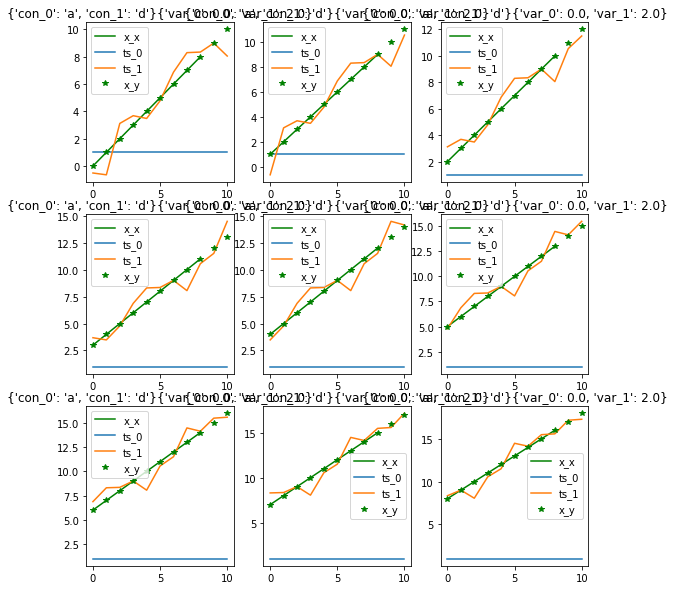

In [201]:
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

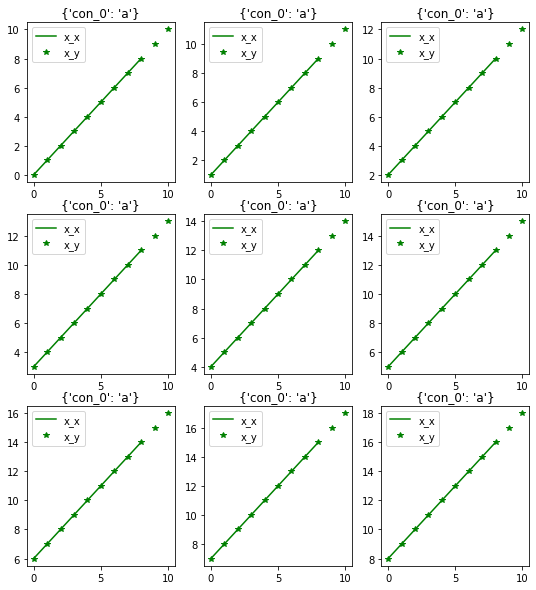

In [202]:
# hide
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

In [203]:
# export

# def _show_results_class(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
#     x,y,its = self.show_batch(b, max_n=max_n, show=False,)
#     x = self.after_item.decode(b)
#     b_out = b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,))
#     x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
#     res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
#     if not show: return res
#     show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)
    
# DfDataLoader.show_results = _show_results_class

In [204]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [205]:
show_results

(TSMulti,object) -> show_results
(TensorSeq,object) -> show_results
(TSMulti,object) -> show_results
(TSMulti,object) -> show_results
(object,object) -> show_results

In [206]:
a = TensorSeqs([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,45892416.0,17339547648.0,'00:00']


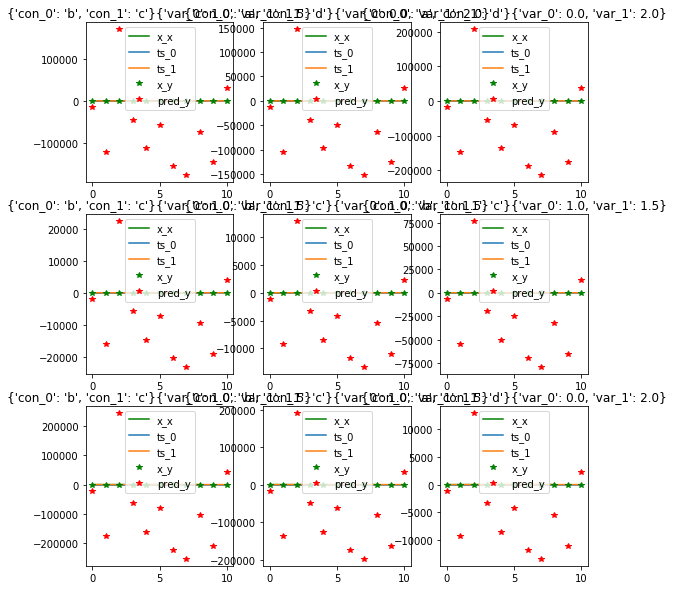

In [207]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

(#4) [0,12603856.0,4762687488.0,'00:00']


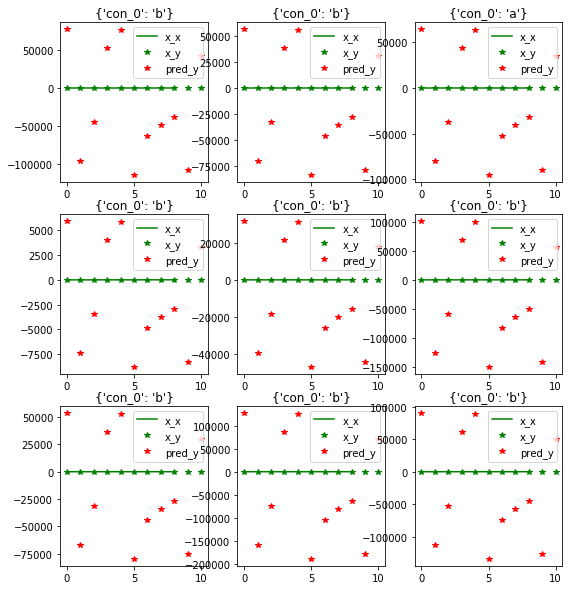

In [208]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

# Intergration Example

In [209]:
from fastseq.data.external import *

In [210]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city'] = df['city']
df.head()

,x,weather,city,cont
0,"[[-0.8081399574070776, -1.349289264763757, -1.4175065531645716, -0.7773122503240281, -0.2486370220625657, 0.7534214996422147, 1.4520924578184577, 2.339507972737756, 1.2922764520228796, 1.0360719645052374, 0.3909762699097508, -0.19049418397922346, -0.22864384602617757, -0.34249829079233113, 0.41588415884544133, 0.4649536644430122, 0.9420936505951232, 1.2355015498924524, 1.5089437188595565, 0.6298984613136706, 0.448876884711011, -0.20439037234770935, -0.9304171639537785, -1.3474750925638665, -1.497570399973825, -1.4948577909269005, -1.2175543625184273, -0.7864216233479437, -0.148552900294723...","[[6.037501163602608, 5.7963031327428265, 6.03962209559883, 6.573449359360692, 7.124316035582128, 7.502684670883882, 7.48203570736314, 6.809650584295241, 5.547337728385404, 4.305303605819695, 3.8735021151324815, 4.488335546350943, 5.549761138250771, 6.179198166030567, 6.0399090519505245, 5.542258341761666, 6.037501163602608, 5.7963031327428265, 6.03962209559883, 6.573449359360692, 7.124316035582128, 7.502684670883882, 7.48203570736314, 6.809650584295241, 5.547337728385404, 4.305303605819695, 3.8735021151324815, 4.488335546350943, 5.549761138250771, 6.179198166030567, 6.0399090519505245, 5.5...",adam,-0.110428
1,"[[1.1510206124545908, 0.24162730509171465, 0.5399328076886076, 0.6231786314067534, 0.16990555330266743, 0.018841820005263965, -0.6928164992233907, -0.17513978625384855, 0.16229182766687517, 1.0711719574941645, 1.1899435360624426, 0.4861067750986368, 0.35754140204708657, 0.9918546945807987, 1.425927124863726, 1.1021094886812322, 1.4204228146749522, 1.2857677667333616, 0.6188463988067198, 0.5045160605260453, -0.10587945138737917, 0.04451496866840433, -1.3734110564717006, -1.3713898631584458, -1.2272948125046543, -0.13585646494728187, -0.8457461234446119, -1.969149636752409, -1.33272089822173...","[[7.525890382983848, 7.0744532324819165, 7.328037341576599, 8.11230076296756, 8.063707076183599, 6.697955085723601, 5.447263153729481, 5.98400716068312, 7.9416850970970785, 9.157391655942355, 8.273176621679559, 6.357856444970755, 5.478867064894434, 6.169539657876607, 7.082520507923888, 7.0554025681451344, 7.525890382983848, 7.0744532324819165, 7.328037341576599, 8.11230076296756, 8.063707076183599, 6.697955085723601, 5.447263153729481, 5.98400716068312, 7.9416850970970785, 9.157391655942355, 8.273176621679559, 6.357856444970755, 5.478867064894434, 6.169539657876607, 7.082520507923888, 7.05...",adam,1.153643
2,"[[0.7623525194657158, 0.8223746954900896, 0.6491179575927276, 0.7992010069016716, 1.1357107844506134, 1.4203081632877728, 1.7029671156342348, 1.507113614653256, 1.0678412757474702, 0.6590721982616053, -0.34022780085678955, -0.8427559773785429, -1.214489445288527, -1.3773156886207052, -1.074983382166033, -0.5482735137184739, 0.45619190597588033, 0.9592452340844349, 1.0275296230657778, 1.0190623069073812, 0.5816164786671448, 0.3219997319988742, -0.2829364900692785, -0.7680645321812225, -0.7776180068531869, -0.8315087735055113, -0.8219002413807918, -0.7899814180874842, -0.9608592000562092, -1...","[[5.674735649199179, 5.461698221706227, 5.178581504182195, 4.9064122465773785, 4.718972839991321, 4.633976646663795, 4.601346381127578, 4.536352192363908, 4.375680692662262, 4.119331882022639, 3.830619148155567, 3.5942723420798006, 3.4603687492625665, 3.411195007464088, 3.3729687255848306, 3.2646631536744906, 5.674735649199179, 5.461698221706227, 5.178581504182195, 4.9064122465773785, 4.718972839991321, 4.633976646663795, 4.601346381127578, 4.536352192363908, 4.375680692662262, 4.119331882022639, 3.830619148155567, 3.5942723420798006, 3.4603687492625665, 3.411195007464088, 3.37296872558483...",adam,-0.475337
3,"[[0.7476056067073771, 0.5535042689378122, 0.5386996311737521, 0.571411599813487, 0.9240036723849367, 1.0226942064981397, 1.219910876215764, 1.7032779042057258, 2.0527898165935072, 2.0073513277985797, 1.1476805924228957, 0.5103436913910114, -0.1235839570483708, -0.16329467984607948, -0.1979521889117415, -0.1620280

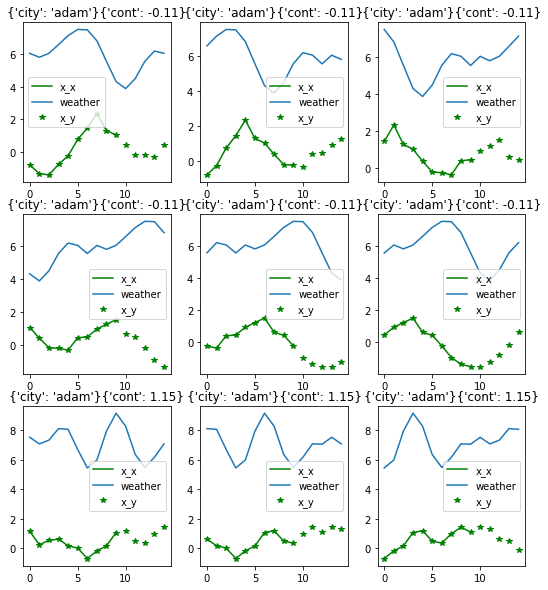

In [211]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

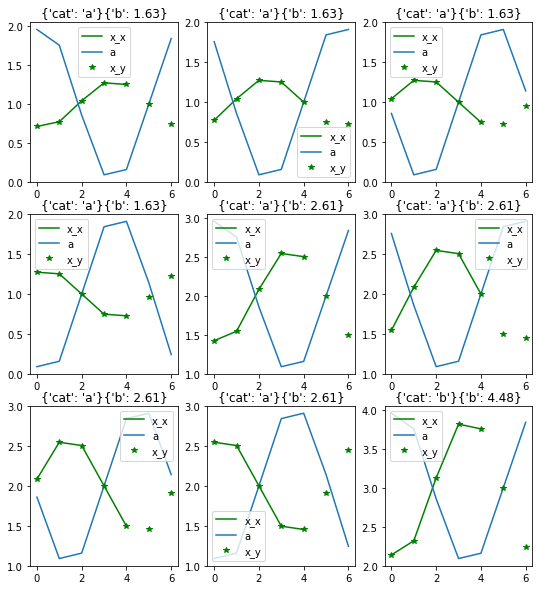

In [212]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
#                   after_batch = NormalizeTSMulti(),
                  num_workers = 1)
dl.show_batch()

# M5 Example

In [213]:
path = Path('../data/m5_tiny')
path.ls()

(#5) [Path('../data/m5_tiny/sales_train_validation.csv'),Path('../data/m5_tiny/sample_submission.csv'),Path('../data/m5_tiny/calendar.csv'),Path('../data/m5_tiny/sales_train_preped.csv'),Path('../data/m5_tiny/sell_prices.csv')]

In [307]:
df_cal = pd.read_csv(path / 'calendar.csv')
df_cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [311]:
df_cal[[c for c in df_cal if 'event' not in c]]

,date,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,0,0,0


FileNotFoundError: [Errno 2] File ../data/m5_tiny/calender.csv does not exist: '../data/m5_tiny/calender.csv'

In [283]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]

In [296]:
# export
def _to_series(df, s_slice=None, add_zeros = 28*2):
    s_slice = ifnone(s_slice, slice(6,None))
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(np.concatenate([df.iloc[i, s_slice].values.astype(float),[0]*add_zeros]) ))
    return r

@delegates(_to_series)
def to_contained_series(df, **kwargs):    
    data={k:v for k,v in dict(df).items() if ('d_' not in k and 'F' not in k)}
    data['sales'] = pd.Series(_to_series(df, **kwargs))
    
    df = pd.DataFrame(data=data)
    return df

In [297]:
df_sales_s = to_contained_series(df_sales)

In [298]:
df_validation = to_contained_series(pd.read_csv(path / 'sample_submission.csv'),
                                    s_slice=slice(1,None), add_zeros = 0) 
df_validation.head()

,id,sales,d
0,HOBBIES_1_001_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64,F1
1,HOBBIES_1_002_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64,F2
2,HOBBIES_1_003_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64,F3
3,HOBBIES_1_004_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64,F4
4,HOBBIES_1_005_CA_1_validation,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 0.0 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0 27 0.0 dtype: float64,F5


In [291]:
lookback, horizon = 28*2, 28
def _id(row):
    return '_'.join(str(row['id']).split('_')[:-1])

df_sales_s_last = to_contained_series(pd.read_csv(path / 'sales_train_validation.csv'),
                                    s_slice=slice(-lookback,None), add_zeros = 28*2)  
df_sales_s_last['sales'] = pd.Series(np.concatenate([df_sales_s_last['sales'].values,[0]*28]))
df_sales_s_last['sales'] = pd.Series(np.concatenate([df_sales_s_last['sales'].values,[0]*28]))
df_sales_s_last.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 2.0 2 0.0 3 1.0 4 1.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 0.0 2 0.0 3 1.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,"0 0.0 1 0.0 2 0.0 3 1.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,"0 1.0 1 2.0 2 1.0 3 0.0 4 0.0 ... 107 0.0 108 0.0 109 0.0 110 0.0 111 0.0 Length: 112, dtype: float64"


In [267]:
for i,row in df_validation.iterrows():
    id = '_'.join(str(row['id']).split('_')[:-1])
    c_row = df_sales_s[df_sales]
    break

SyntaxError: invalid syntax (<ipython-input-267-21cf22f71cf6>, line 9)

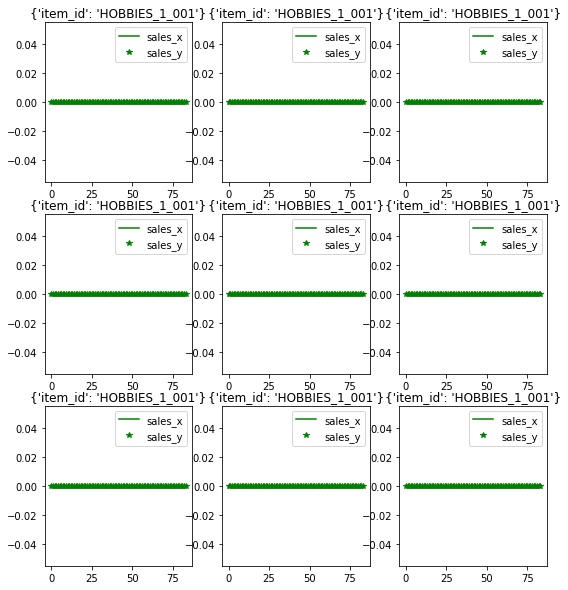

In [234]:
dl =  DfDataLoader(df_sales_s.loc[:,['sales','item_id']], 'sales', horizon = 28, lookback=28*2, step=7)
dl.show_batch(max_n=9)

In [38]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.model_M5.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.
